## План

0.1) Как-то разбираюсь с визуализацией в python

0.2) Как-то разбираюсь с теорией

1) Пишу нейронку, вычисляющую нормали, на pytorch, пользуясь [automatic differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

2) Сверяясь с тем, что получает pytorch, выражаю производные и переписываю на чистом numpy.

3) как-то разбираюсь с визуализацией в javascript

4) Переписываю нейронку на javascript, чтобы получить демку-html-страничку

# Demo in Python

Let's just explore some math and then we'll rewrite it to javascript.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

## Plotting SDF

[example](https://matplotlib.org/examples/images_contours_and_fields/pcolormesh_levels.html) from documentation

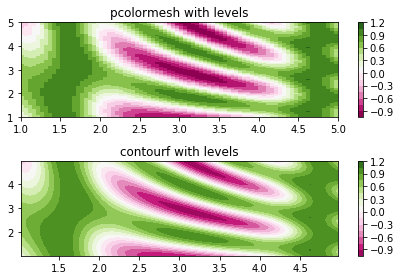

In [3]:
"""
Shows how to combine Normalization and Colormap instances to draw
"levels" in pcolor, pcolormesh and imshow type plots in a similar
way to the levels keyword argument to contour/contourf.

"""

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np


# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(1, 5 + dy, dy),
                slice(1, 5 + dx, dx)]

z = np.sin(x)**10 + np.cos(10 + y*x) * np.cos(x)

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1) = plt.subplots(nrows=2)

im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')


# contours are *point* based plots, so convert our bound into point
# centers
cf = ax1.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., z, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()

SDF for circle with radius 3, and center at (1, 2)

In [4]:
x0 = 1
y0 = 2
r = 3
sdf_circle = lambda x, y: np.sqrt((x - x0) ** 2 + (y - y0) ** 2) - r

Let's plot it!

Text(0.5, 1.0, 'pcolormesh with levels')

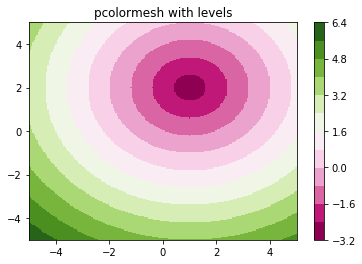

In [7]:
dx, dy = 0.05, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-5, 5 + dy, dy),
                slice(-5, 5 + dx, dx)]

z = sdf_circle(x, y)

z = z[:-1, :-1]
levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())

cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax0 = plt.subplots(nrows=1)

im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')


## Формальная постановка задачи ML

Поставим задачу supervised learning. Дана обучающая выборка из n пар {(x, y), SDF(x, y)}, где
  - (x, y) — точка на плоскости
  - SDF(x, y) — значение signed distance fucntion в этой точке
  
Необходимо восстановить signed distance function на всей плоскости.

## Нейронка

Давайте предсказывать signed distance function до 2D фигуры нейронкой с одним скрытым слоем. В качестве нелинейности возьмём, например, тангенс. К выходному слою никакой нелинейности применять не будем.

<img src="architecture.png">

$z_1 = w^{[1]}_{11}x + w^{[1]}_{12}y + b^{[1]}_1$

$z_2 = w^{[1]}_{21}x + w^{[1]}_{22}y + b^{[1]}_2$

$z_3 = w^{[1]}_{31}x + w^{[1]}_{32}y + b^{[1]}_3$

$z_4 = w^{[1]}_{41}x + w^{[1]}_{42}y + b^{[1]}_4$


$a_1 = tanh(z_1)$

$a_2 = tanh(z_2)$

$a_3 = tanh(z_3)$

$a_4 = tanh(z_4)$

$ S = w^{[2]}_{11}a_1 + w^{[2]}_{12}a_2 
    + w^{[2]}_{13}a_3 + w^{[2]}_{14}a_4$

В качестве функции потерь возьмём MSE.

$$Loss(W, b) = \frac{1}{n}\sum_{i = 1}^{n} (S(W, b, x_i, y_i) - SDF(x_i, y_i))^2$$

## Восстановление нормалей

Вектор нормали к точке (x, y) на поверхности, signed distance function до которой предсказывает наша нейронка, выражается так:

$$\vec{n} = (\frac{dS}{dx}, \frac{dS}{dy})^T$$

## Pytorch

Просто тыкаю pytorch, осознавая, что делает `.backward()`

In [8]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [9]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [10]:
print(y.grad_fn)

In [11]:
z = y * y * 3
out = z.mean()

In [12]:
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward1>)


In [13]:
out.backward()

In [14]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
